In [1]:
from dgl.data import FB15kDataset
import torch
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader
import pandas as pd 

/opt/conda/envs/recbole/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
FB15kDataset()

# entities: 14951
# relations: 1345
# training edges: 483142
# validation edges: 50000
# testing edges: 59071
Done loading data from cached files.


Dataset("FB15k", num_graphs=1, save_path=/opt/ml/.dgl/FB15k_07be685f)

In [92]:
# load data
dataset = FB15kDataset()
graph = dataset[0]

# get training mask
train_mask = graph.edata['train_mask']
train_idx = torch.nonzero(train_mask, as_tuple=False).squeeze()
head, tail = graph.edges._graph.find_edges(train_idx)
# get edge types in training set
label = graph.edata['etype'][train_idx]
print(len(head), len(tail), len(label))

# entities: 14951
# relations: 1345
# training edges: 483142
# validation edges: 50000
# testing edges: 59071
Done loading data from cached files.
966284 966284 966284


In [118]:
class TransE(nn.Module):
    def __init__(self, num_entities: int, num_relations: int, embedding_dim: int):
        super().__init__()
        self.num_entities = num_entities
        self.num_relations = num_relations
        self.k = embedding_dim
        self.entity_embedding = nn.Embedding(num_entities, embedding_dim)
        self.relation_embedding = nn.Embedding(num_relations, embedding_dim)
        self.initialize()
        
    def initialize(self):
        nn.init.uniform_(self.entity_embedding.weight.data, -6/self.k, 6/self.k)
        nn.init.uniform_(self.relation_embedding.weight.data, -6/self.k, 6/self.k)
        
        self.relation_embedding.weight.data = self.relation_embedding.weight.data / torch.norm(self.relation_embedding.weight.data, dim=1, keepdim=True)
    
    def norm_entity(self):
        self.entity_embedding.weight.data = self.entity_embedding.weight.data / torch.norm(self.entity_embedding.weight.data, dim=1, keepdim=True)
        
    def forward(self, head: torch.Tensor, tail: torch.Tensor, label: torch.Tensor):
        head_embedding = self.entity_embedding(head)
        tail_embedding = self.entity_embedding(tail)
        relation_embedding = self.relation_embedding(label)
        
        score = torch.norm(head_embedding + relation_embedding - tail_embedding, dim=1)
        return score
    

In [117]:
graph.num_nodes()

14951

In [124]:
class FB15k(Dataset):
    def __init__(self, graph, idx):
        self.head, self.tail = graph.edges._graph.find_edges(idx)
        self.label = graph.edata['etype'][idx]
        self.num_entities = graph.num_nodes()
        
    def __len__(self):
        return len(self.head)
    
    def __getitem__(self, idx):
        return self.head[idx], self.label[idx], self.tail[idx] 
    
    def make_neg_samples(self, num_neg_samples: int, entities):
        neg_samples = []
        for entity in entities:
            neg_samples.extend([entity] * num_neg_samples)

In [ ]:
def make_neg_samples(num_neg_samples, entities):
    neg_samples = []
    for entity in entities:
        neg_samples.append(torch.randint(0, num_entities, (num_neg_samples,)))
    

In [125]:
def split_dataset(graph, batch_size=128):
    train_mask, val_mask, test_mask = graph.edata['train_mask'], graph.edata['val_mask'], graph.edata['test_mask']
    
    train_idx = torch.nonzero(train_mask, as_tuple=False).squeeze()
    val_idx = torch.nonzero(val_mask, as_tuple=False).squeeze()
    test_idx = torch.nonzero(test_mask, as_tuple=False).squeeze()
    
    train_dataset = FB15k(graph, train_idx)
    val_dataset = FB15k(graph, val_idx)
    test_dataset = FB15k(graph, test_idx)
    
    train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False)
    
    
    return train_dataloader, val_dataloader, test_dataloader

In [135]:
dataset = FB15kDataset()
graph = dataset[0]
train_dataloader, val_dataloader, test_dataloader = split_dataset(graph,4)

# entities: 14951
# relations: 1345
# training edges: 483142
# validation edges: 50000
# testing edges: 59071
Done loading data from cached files.


In [136]:
model = TransE(graph.num_nodes(), graph.num_edges(), 50)

In [137]:
head, label, tail = next(iter(train_dataloader))

In [142]:
pred = model(head,label,tail)

In [150]:
torch.cat([pred, neg_pred], dim=0)

tensor([1.1264, 1.1560, 1.2738, 1.0391, 1.1043, 1.0790, 1.2637, 1.3209],
       grad_fn=<CatBackward0>)

In [148]:
neg = torch.randint(0, 14951, (4,))
neg_pred = model(head, label, neg)

In [155]:
-1 * torch.ones(4)

tensor([-1., -1., -1., -1.])

In [156]:
nn.MarginRankingLoss(0.1)(pred, neg_pred, -1 * torch.ones(4))

tensor(0.1023, grad_fn=<MeanBackward0>)

In [178]:
neg_tail

tensor([ 6474,  3487, 13227,  8967, 13721, 12050,  1396,  6958])

In [179]:
head

tensor([2267,  354,  178, 4885, 2267,  354,  178, 4885, 2267,  354,  178, 4885,
        2267,  354,  178, 4885])

In [192]:
neg.size()

torch.Size([16])

In [191]:
pos.size()

torch.Size([16])

In [188]:
head.size()

torch.Size([8])

In [195]:
epochs = 30 
model = TransE(graph.num_nodes(), graph.num_edges(), 50)
neg_num = 2
criterion = nn.MarginRankingLoss(0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
batch = 4

for epoch in range(epochs):
    model.norm_entity()
    total_loss = 0

    for head, label, tail in train_dataloader:
        head, label, tail = head.repeat(neg_num) , label.repeat(neg_num), tail.repeat(neg_num)
        pos = model(head, label, tail).repeat(2)
        neg_head, neg_tail = torch.randint(0, 14951, (batch * neg_num,)), torch.randint(0, 14951, (batch * neg_num,))
        neg = torch.cat([model(head, label, neg_tail), model(neg_head, label, tail)], dim = 0)
        
        loss = criterion(pos, neg, -1 * torch.ones(batch * neg_num * 2))
        optimizer.zero_grad() 
        loss.backward()
        
        total_loss += loss.item()
        
        optimizer.step()
        
    print(total_loss // len(train_dataloader))
        

KeyboardInterrupt: 

In [158]:
pred = pred.repeat(3)
pred

tensor([1.1264, 1.1560, 1.2738, 1.0391, 1.1264, 1.1560, 1.2738, 1.0391, 1.1264,
        1.1560, 1.2738, 1.0391], grad_fn=<RepeatBackward0>)

In [141]:
head

tensor([ 9159, 14794,   385,  8600])

In [1]:
import pandas as pd
summary = pd.read_csv('../../../Recsys/SoRec/summary.csv')

In [2]:
summary

,epoch,rating_loss,social_loss,test_loss
0,0,0.655183,0.065618,0.651157
1,1,0.628900,0.063489,0.650701
2,2,0.591792,0.061213,0.649936
3,3,0.559054,0.059094,0.648752
4,4,0.530021,0.057119,0.647057
...,...,...,...,...
295,295,0.023786,0.002374,0.398613
296,296,0.023271,0.002374,0.398608
297,297,0.023562,0.002368,0.398608
298,298,0.023436,0.002363,0.398589


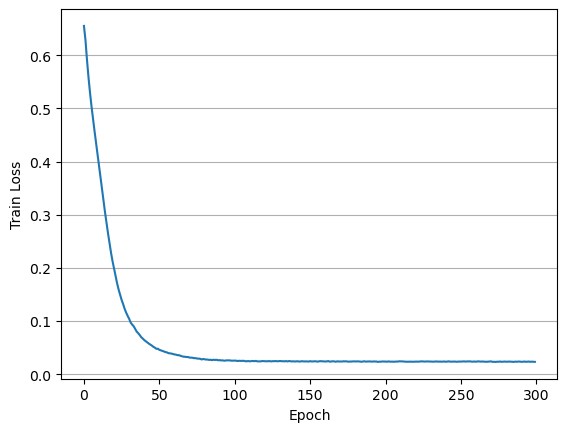

In [4]:
result_df = summary[['epoch','rating_loss']]
import matplotlib.pyplot as plt

x = result_df['epoch'].values
y = result_df['rating_loss'].values

plt.plot(x, y)
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.grid(axis = 'y')
plt.show()

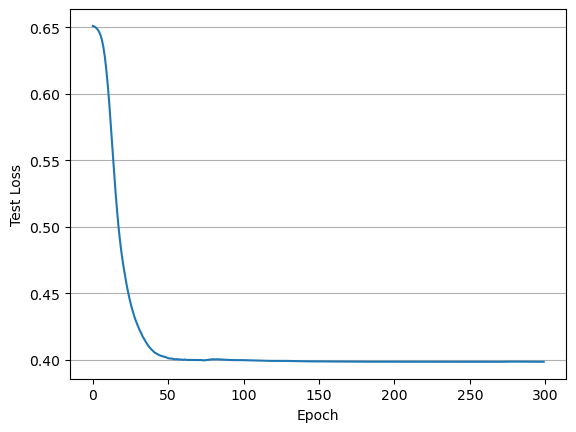

In [5]:
result_df = summary[['epoch','test_loss']]
import matplotlib.pyplot as plt

x = result_df['epoch'].values
y = result_df['test_loss'].values

plt.plot(x, y)
plt.xlabel('Epoch')
plt.ylabel('Test Loss')
plt.grid(axis = 'y')
plt.show()

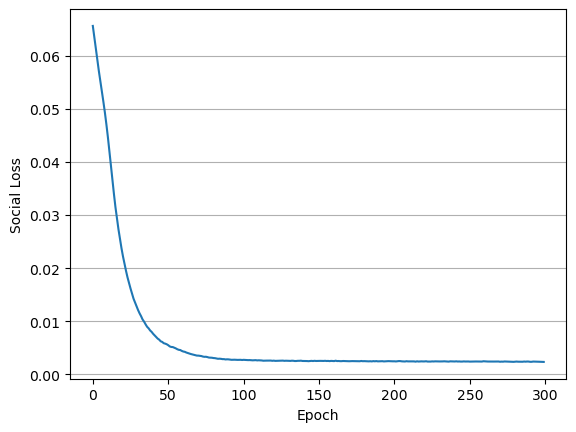

In [6]:
result_df = summary[['epoch','social_loss']]
import matplotlib.pyplot as plt

x = result_df['epoch'].values
y = result_df['social_loss'].values

plt.plot(x, y)
plt.xlabel('Epoch')
plt.ylabel('Social Loss')
plt.grid(axis = 'y')
plt.show()